In [1]:
# Code for analyzing NFL big data bowl data (probably with Celia!!!)

In [9]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import andrewFunctions as nfldf
import fileManagement as fm

In [11]:
games, players, plays, pffData = fm.loadData()
weekData = fm.loadWeek()

In [58]:
# plays.select(pl.col("playDescription"))[0].item()
incompletes = plays.select(pl.col("playDescription").where(pl.col("passResult")=='I'))
incompletes[8].item()

'(7:43) (Shotgun) N.Foles pass incomplete deep right to D.Goedert (D.Riley).'

In [88]:
playWeek = nfldf.playWeek(games, plays)

In [448]:
# Code to identify target Receiver
itrOutputs = nfldf.identifyTargetReceiver(weekData[0],plays,playWeek,weekId=1)
receiverName, validPlay, descName, receiverDistance, receiverNextClosestDistance, qbNflID = itrOutputs

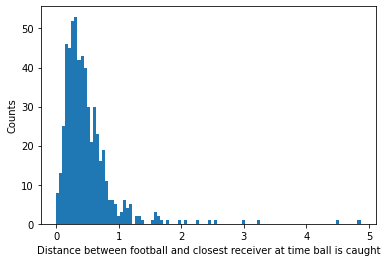

In [419]:
plt.hist(receiverDistance,100)
plt.xlabel("Distance between football and closest receiver at time ball is caught")
plt.ylabel("Counts")
plt.show()

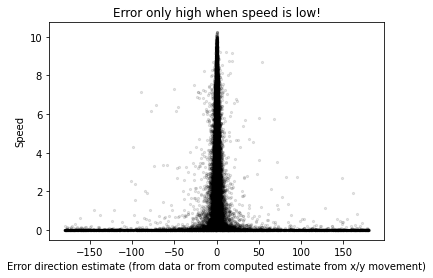

In [457]:
# Collect movement data for target receivers on each play
rvcOutputs = nfldf.receiverVelocityCheck(weekData[0],plays,playWeek,weekId=1)
dx,dy,spd,ang,speed,direction = rvcOutputs

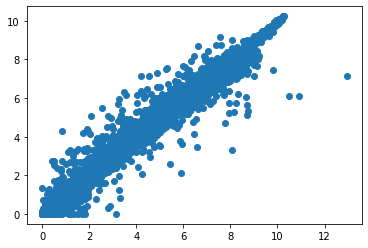

In [459]:
plt.scatter(spd*10, speed)

In [442]:
# next step-- measure relationship between location of ball being caught by receiver and expected location given speed and direction and previous location 
# I guess I should pick a certain timing? 
def deviationFromPredictedCatchLocation(week,plays,playWeek,framesBefore,weekId=None):
    """
    """
    completions = nfldf.getCompletions(plays, playWeek, weekId) # start by identify ing 
    numCompletions = len(completions)
    
    # create some arrays for saving the data about the pass reception
    event2use = ['pass_outcome_caught', 'pass_outcome_touchdown', 'pass_arrived']
    validPlay = np.full(numCompletions, False)
    locPlayerAtCatch = np.zeros((numCompletions,2))
    locFootballAtCatch = np.zeros((numCompletions,2))
    locPlayerExpected = np.zeros((numCompletions,2))
    distanceAtCatch = np.zeros(numCompletions)
    distanceExpected = np.zeros(numCompletions)
    for idx, gameIdPlayId in enumerate(zip(completions['gameId'],completions['playId'])):
        gameId, playId = gameIdPlayId
        
        # get the current play description -- which contains an abbreviation of which player received the catch
        playIdx = (week['gameId']==gameId) & (week['playId']==playId)
        currentPlay = week.loc[playIdx] # dataframe containing values from current play
        currentPlayDescription = plays.loc[(plays['gameId']==gameId) & (plays['playId']==playId), ['playDescription']].iloc[0].iloc[0]
        
        # check if there is a single forward pass (otherwise it's a confusing and weird play... probably)
        validPlay[idx] = np.sum(currentPlay.loc[currentPlay['team']=='football']['event']=='pass_forward')==1
        if not(validPlay[idx]): continue
            
        # Check if there's a valid QB (i.e. if only one nflId shows up at the QB position...)
        cID = np.unique(currentPlay.loc[currentPlay['position']=='QB','nflId'])

        # If so, add it to the register, otherwise, skip this play
        if len(cID)!=1: 
            validPlay[idx] = False
            continue

        # Get which team is on offense (it's either "home" or "away", rather than the city name from plays, wtf)
        teamOffense = currentPlay.loc[currentPlay['nflId']==cID[0],'team'].iloc[0]

        # Find out row of frame when pass was caught
        # these are the possible events: pass_arrived, pass_forward, pass_outcome_caught - I don't know what they all mean yet
        idxEvent = 0
        footballCaughtPosition = currentPlay.loc[(currentPlay['team']=='football') & (currentPlay['event']==event2use[0])]
        if len(footballCaughtPosition)!=1: 
            # that means it's a touchdown
            idxEvent = 1
            footballCaughtPosition = currentPlay.loc[(currentPlay['team']=='football') & (currentPlay['event']==event2use[1])]
        if len(footballCaughtPosition)!=1: 
            # that means it's at the "pass_arrived" event
            idxEvent = 2
            footballCaughtPosition = currentPlay.loc[(currentPlay['team']=='football') & (currentPlay['event']==event2use[2])]
        if len(footballCaughtPosition)!=1:
            raise ValueError("Couldn't figure out when the ball was caught on this play...")
        
        idxCaughtFrame = np.where((currentPlay['team']=='football') & (currentPlay['event']==event2use[idxEvent]))[0][0]
        frameId = currentPlay['frameId'].iloc[idxCaughtFrame]
        
        # Find out where the ball was caught
        catchLocation = [footballCaughtPosition['x'].iloc[0],footballCaughtPosition['y'].iloc[0]]
        locFootballAtCatch[idx] = catchLocation
        
        # Find out where all offensive players are when the ball was caught
        offenseSnapshot = currentPlay.loc[(currentPlay['team']==teamOffense) & (currentPlay['event']==event2use[idxEvent])]
        offenseLocation = np.array(offenseSnapshot[['x','y']])
        distanceFromFootball = np.sqrt(np.sum((offenseLocation - catchLocation)**2,axis=1))
        idxDistanceFromFootball = np.argsort(distanceFromFootball)
        
        # Predict where receiver would have been if their velocity was constant from $framesBefore frames before the catch
        receiverId = offenseSnapshot.iloc[idxDistanceFromFootball[0]]['nflId']
        receiverPrior = currentPlay.loc[(currentPlay['nflId']==receiverId)].iloc[frameId - framesBefore]
        receiverPriorPosition = np.array(receiverPrior[['x','y','s','a','dis','o','dir']])
        
        # need to code this in - add a line to predict future x/y from current x/y, s, and dir. Note that s is in yard/sec, but each frame is 0.1seconds
        
        print(receiverPriorPosition)
        
        # Store location of receiver at catch
        locPlayerAtCatch[idx] = offenseLocation[idxDistanceFromFootball[0]]
        
        # Measure distance of receiver at catch and expected distance from prior position/velocity
        distanceAtCatch[idx] = distanceFromFootball[idxDistanceFromFootball[0]]
        
        
        print(locFootballAtCatch[idx])
        print(locPlayerAtCatch[idx])
        print(distanceAtCatch[idx])
        print(receiverId)
        
        
        break
        
        
        receiverDistance[idx] = distanceFromFootball[idxDistanceFromFootball[0]]
        receiverNextClosestDistance[idx] = distanceFromFootball[idxDistanceFromFootball[1]]
        receiverName[idx] = offenseSnapshot['displayName'].iloc[idxDistanceFromFootball[0]]

        # Get name of receiver from play description ("QB pass to ReceiverNameAbbreviated ...")
        toIdx = currentPlayDescription.find(' to ')+4
        nextSpaceIdx = currentPlayDescription[toIdx:].find(' ')
        descName[idx] = currentPlayDescription[toIdx:toIdx+nextSpaceIdx]
    
    return receiverName, descName, receiverDistance, receiverNextClosestDistance, qbNflID, validPlay

itrOutputs = deviationFromPredictedCatchLocation(weekData[0],plays,playWeek,framesBefore=0,weekId=1)

[81.4 50.67 5.27 3.53 0.54 325.43 352.3]
[81.52 50.88]
[81.48 50.13]
0.7510659092250156
2495454.0


In [59]:
# plays.select(pl.col("playDescription"))[0].item()
incompletes = plays.select(pl.col("playDescription").where(pl.col("passResult")=='I'))
incompletes[8].item()

'(7:43) (Shotgun) N.Foles pass incomplete deep right to D.Goedert (D.Riley).'

In [ ]:
# Code to identify unique abbreviations in play descriptions of plays resulting in completions
uniqAbbreviations = nfldf.checkAbbreviatedNames(plays)
# for abb in uniqAbbreviations: print(abb)

In [301]:
# Showing some plays where the two closest receivers were a similar distance from the football
fsDiff = receiverNextClosestDistance-receiverDistance
idxCloseSecond = np.where(fsDiff<2)[0]
for idx in idxCloseSecond:
    print(f"idx: {idx} Target receiver: {receiverName[idx]}, descName: {descName[idx]}")

idx: 31 Target receiver: Mohamed Sanu, descName: M.Sanu
idx: 51 Target receiver: Jarvis Landry, descName: J.Landry
idx: 93 Target receiver: T.Y. Hilton, descName: T.Hilton
idx: 119 Target receiver: Tyler Boyd, descName: T.Boyd
idx: 227 Target receiver: DeAndre Hopkins, descName: D.Hopkins
idx: 252 Target receiver: Ryan Griffin, descName: D.Hopkins
idx: 362 Target receiver: Larry Fitzgerald, descName: L.Fitzgerald
idx: 390 Target receiver: David Johnson, descName: D.Johnson
idx: 433 Target receiver: Taylor Gabriel, descName: T.Gabriel
idx: 451 Target receiver: Anthony Miller, descName: A.Miller
idx: 530 Target receiver: Todd Gurley, descName: T.Gurley


In [508]:
# next step-- measure relationship between location of ball being caught by receiver and expected location given speed and direction and previous location 
# I guess I should pick a certain timing? 
from datetime import datetime

def checkFrameDeltaTime(week,plays,playWeek,weekId=None):
    """
    
    """
    weekBool = np.full(playWeek.shape,True) if weekId is None else playWeek==weekId
    usePlays = plays[weekBool]
    
    secondDiffs = []
    for idx, gameIdPlayId in enumerate(zip(usePlays['gameId'],usePlays['playId'])):
        gameId, playId = gameIdPlayId
        
        playIdx = (week['gameId']==gameId) & (week['playId']==playId) & (week['team']=='football')
        currentPlayFrames = np.array(week.loc[playIdx]['time'])
        currentPlayDatetimes = [datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.%fZ') for s in currentPlayFrames]
        secondDiffs.append(np.array([(n-p).total_seconds() for (n,p) in zip(currentPlayDatetimes[1:], currentPlayDatetimes[:-1])]))
        
    return np.unique(np.concatenate(secondDiffs))

%time timeDiffs = checkFrameDeltaTime(weekData[0],plays,playWeek,weekId=1)
print(timeDiffs.shape)
print(timeDiffs)

CPU times: user 46.7 s, sys: 26.8 ms, total: 46.7 s
Wall time: 46.7 s
(5,)
[0.    0.099 0.1   0.101 1.   ]


In [ ]:
timeDiffs

In [504]:
len(timeDiffs)

58